# Force Optimizations Data Analysis 

## Table of contents
- [Landreman-Paul 2021 Precise QA](#landreman-paul-2021-precise-qa)
    - [Ensemble of Optimizations](#ensemble-of-optimizations)
        - [With Force Penalty](#with-force-penalty)
        - [Without Force Penalty](#without-force-penalty)
        - [Comparison](#comparison)
    - [Magnetic Field Analysis](#magnetic-field-analysis)
        - [Computing Equilibria](#computing-equilibria)
        - [Quasisymmetry Measures](#quasisymmetry-measures)
        - [Fast Particle Tracing](#fast-particle-tracing)
        - [Poincaré Plots](#poincaré-plots)
- [Landreman-Paul 2021 Precise QH + Well](#landreman-paul-2021-precise-qh--well)
    - [Ensemble of Optimizations](#1)
        - [With Force Penalty](#2)

In [2]:
from analysis_tools import *
from optimization_tools import *
import imageio
import matplotlib
import matplotlib.pyplot as plt
import os

DESC version 0.11.1,using JAX backend, jax version=0.4.30, jaxlib version=0.4.30, dtype=float64
Using device: CPU, with 16.02 GB available memory


## Landreman-Paul 2021 Precise QA

### Ensemble of Optimizations

#### With Force Penalty

First, we perform our initial optimizations using the random (educated) guesses for the weights on the objective function. As these optimizations demand significant computational resources, the code is commented out for the purpose of this example. 

In [ ]:
# initial_optimizations()

Let's double check that we made good choices for our hyperparameters! These plots show histograms of the optimizations with regard to numerous parameters, plotted both before and after filtering.

/var/folders/qx/zl9pfmpn3yz5f62mt03d1m5w0000gs/T/ipykernel_26846/2196737898.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  success_plt(df, df_filtered).show()


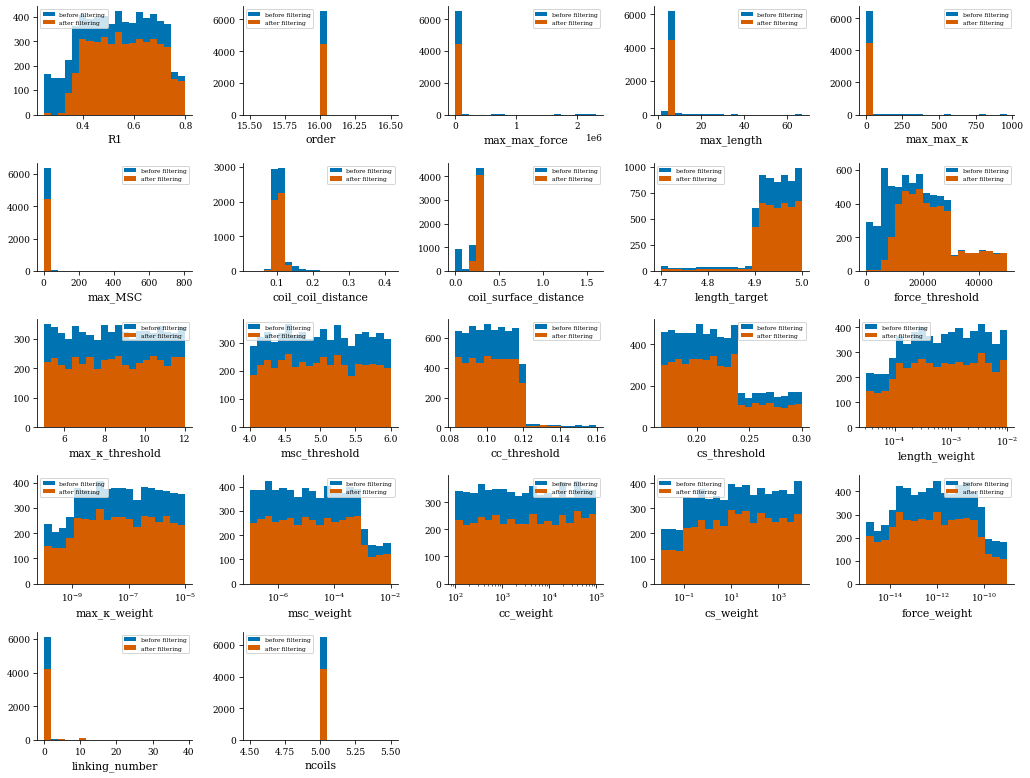

In [8]:
df, df_filtered, df_pareto = get_dfs()
success_plt(df, df_filtered).show()

We next analyze our set of optimizations and parse the data into three DataFrames: `df`, representing the full set of optimizations; `df_filtered`, representing the set of optimizations that passed pre-specified filtering criteria; and `df_pareto1`, representing the set of optimizations on the Pareto front. (This method also exports the Universally Unique Identifiers (unique identifiers for each optimization) of the Pareto front to 
`pareto.txt`). 

In [ ]:
df, df_filtered, df_pareto = get_dfs()

fig = plt.figure(figsize=(6.5, 8))
plt.rc("font", size=13)
markersize = 5
n_pareto = df_pareto.shape[0]
n_filtered = df_filtered.shape[0] - n_pareto
color="coil_surface_distance"
color_label="coil-surface distance [m]"
norm = plt.Normalize(min(df_filtered[color]), max(df_filtered[color]))
plt.scatter(
    df_filtered["normalized_BdotN"],
    df_filtered["max_max_force"],
    c=df_filtered[color],
    s=markersize,
    label=f'all optimizations, N={n_filtered}',
    norm=norm
)
plt.scatter(
    df_pareto["normalized_BdotN"], 
    df_pareto["max_max_force"], 
    c=df_pareto[color], 
    marker="+",
    label=f'Pareto front, N={n_pareto}',
    norm=norm,
)
plt.xlabel(r'$\langle|\mathbf{B}\cdot\mathbf{n}|\rangle/\langle B \rangle$ [unitless]')
plt.ylabel("max force [N/m]")
plt.xlim(0.7 * min(df_filtered["normalized_BdotN"]), max(df_filtered["normalized_BdotN"]))
plt.ylim(8500, 25000)
plt.xscale("log")
plt.colorbar(label=color_label)
plt.clim(0.17, 0.31)
plt.legend(loc='upper right', fontsize='11')
plt.title('Pareto Front')
plt.show()

Now, let us perform the first iteration of our continuation method. Here, we perform the first iteration and allow the maximum variation in any parameter to be a randomly chosen number in the range $10^{-3}$ to $5\times 10^{-2}$. From this point, it is possible to perform the $i+1$-th iteration of the continuation method by using the $i$-th Pareto fronts as input.

In [ ]:
for i in range(1000): continuation(N=1, dx = 10**rand(-3, -1.3))

Next, we can also export the Pareto fronts unique folders for easy access. 

In [ ]:
# for folder in os.listdir("./output/QA/with-force-penalty"):
#     f = os.path.join("./output/QA/with-force-penalty", folder)
#     if not os.path.isfile(f):
#         get_dfs(INPUT_DIR = f"{f}/optimizations/", OUTPUT_DIR=f"{f}/pareto/")

Note that a set of alternative files ("continuation.py", "gen_pareto.py", and "continuation.sh") are provided in the "HPC files" directory. These are designed to allow for a low-input execution of the continuation method on a Slurm-based HPC system. To use them, for example, one could submit the following over the command line on the HPC system:

```
sbatch continuation.sh 2 
sbatch -d afterok:<last_job_from_continuation1> continuation.sh 3
sbatch -d afterok:<last_job_from_continuation2> continuation.sh 4
```

Note that we choose the keyword "afterok" as it only allows for execution after all jobs in the job array are completed.

Now, let us see how performing the continuation method impacts our Pareto fronts. 

/var/folders/qx/zl9pfmpn3yz5f62mt03d1m5w0000gs/T/ipykernel_11827/2057318111.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  norm = plt.Normalize(1, np.sum(os.path.isdir(os.path.join("./output/QA/with-force-penalty", f)) for f in os.listdir("./output/QA/with-force-penalty")))


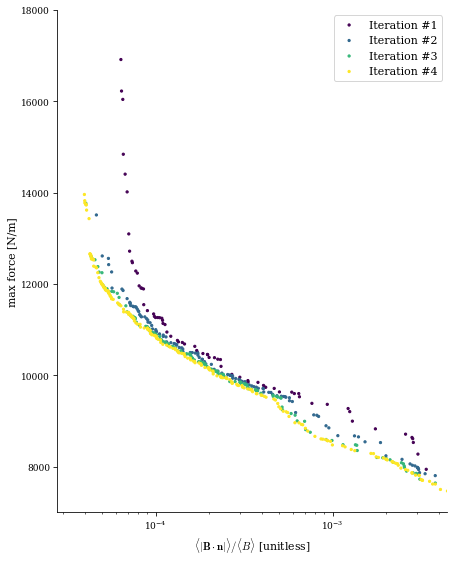

In [3]:
fig = plt.figure(figsize=(6.5, 8))
norm = plt.Normalize(1, np.sum(os.path.isdir(os.path.join("./output/QA/with-force-penalty", f)) for f in os.listdir("./output/QA/with-force-penalty")))
plt.rc("font", size=13)
for filename in sorted(os.listdir("./output/QA/with-force-penalty")):
    f = os.path.join("./output/QA/with-force-penalty", filename)
    if os.path.isdir(f):
        *_, df = get_dfs(INPUT_DIR = f + "/optimizations/")
        plt.scatter(
            df["normalized_BdotN"],
            df["max_max_force"],
            s=5,
            c=int(filename)*np.ones(len(df["UUID"])),
            label=f"Iteration #{filename}",
            norm=norm
        )
        
plt.xlabel(r'$\langle|\mathbf{B}\cdot\mathbf{n}|\rangle/\langle B \rangle$ [unitless]')
plt.ylabel("max force [N/m]")
plt.xlim(0.7 * min(df["normalized_BdotN"]), max(df["normalized_BdotN"]))
plt.ylim(7000, 18000)
plt.xscale("log")
plt.legend(loc='upper right', fontsize='11')
plt.show()

Here, we create an interactive plot of the Pareto front. This is particularly useful for identifying specific optimizations visually based on their UUID. 

In [ ]:
df_final, df_filtered_final, df_pareto_final = get_dfs(INPUT_DIR='./output/QA/with-force-penalty/4/optimizations/')
pareto_interactive_plt(df_pareto_final).show()

An interesting thing to analyze are the Pearson's R correlations between the maximum force on a coil and other optimization parameters. Interestingly, we see that the strongest correlation by far is with the coil-surface distance. 



Correlations with maximum force:
|    | Parameter             |           R |            P |
|---:|:----------------------|------------:|-------------:|
| 16 | max_max_force         |  1          | 0            |
| 11 | force_threshold       |  0.998699   | 0            |
| 21 | coil_surface_distance |  0.949217   | 0            |
| 18 | mean_RMS_force        |  0.947019   | 0            |
| 17 | min_min_force         |  0.700603   | 7.19271e-229 |
|  1 | length_target         |  0.332135   | 3.49816e-41  |
| 20 | coil_coil_distance    |  0.323327   | 5.33236e-39  |
|  2 | length_weight         |  0.154985   | 8.78901e-10  |
|  9 | cs_threshold          |  0.142949   | 1.61589e-08  |
|  4 | max_κ_weight          |  0.131633   | 2.01999e-07  |
|  7 | cc_threshold          |  0.0143851  | 0.5717       |
|  8 | cc_weight             |  0.00978367 | 0.700509     |
| 13 | max_length            | -0.0132361  | 0.602806     |
|  6 | msc_weight            | -0.0245908  | 0.333604     |
| 10 

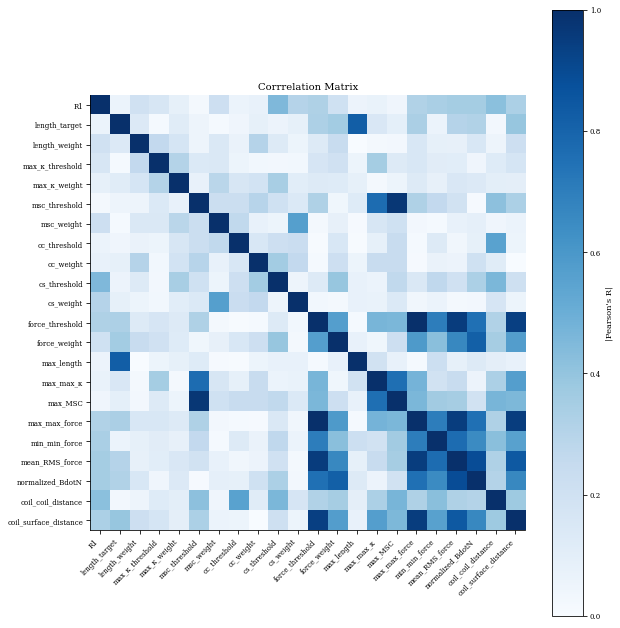

In [3]:
df_final, df_filtered_final, df_pareto_final = get_dfs(INPUT_DIR='./output/QA/with-force-penalty/4/optimizations/')
print("\n\nCorrelations with maximum force:")
print(parameter_correlations(df_filtered_final, sort_by="max_max_force").to_markdown())
print("\n\nCorrelations with RMS force:")
print(parameter_correlations(df_filtered_final, sort_by="mean_RMS_force").to_markdown())
_ = parameter_correlations(df_filtered_final, sort_by="max_max_force", matrix=True)

##### Plotting the Coils
*In the following examples, we will use the UUIDs* 6266c8d4bb25499b899d86e9e3dd2ee2 *and* c3c984ea02624607b8a59a9fdf0642dd *as examples in order to showcase various plots. The former UUID represents the optimum furthest left on the Pareto front, while the latter UUID represents one on the mid-right of the front.*

Let's save various 2D plots for each of the coils along the Pareto front!

In [ ]:
# fig = mlab.figure(bgcolor=(1,1,1), fgcolor=(0,0,0), size=(1200,1200))
# mlab.options.offscreen = True

# IN_PATH = "./output/QA/with-force-penalty/4/pareto/"
# UUIDs = [f.name for f in os.scandir(IN_PATH) if f.is_dir()]
# for UUID in UUIDs:
#     path = IN_PATH + UUID + "/"
#     for arrow in [None, "mutual", "self", "force"]:
#         arr = plot_coils(path + "biot_savart.json", fig=fig, arrow=arrow)
#         mlab.clf()
#         if arrow is None:
#             plt.imsave(path + f"coilplot.jpeg", arr)
#         else:
#             plt.imsave(path + f"coilplot_{arrow}.jpeg", arr)

UUIDs = ["6266c8d4bb25499b899d86e9e3dd2ee2", "c3c984ea02624607b8a59a9fdf0642dd"]
for UUID in UUIDs:
    IN_PATH = "./output/QA/4/pareto/"
    img = matplotlib.image.imread(IN_PATH + UUID + "/coilplot_force.jpeg")
    plt.figure()
    imgplot = plt.imshow(img)

We can also view these as interactive 3D plots:

In [ ]:
# UUIDs = ["6266c8d4bb25499b899d86e9e3dd2ee2", "c3c984ea02624607b8a59a9fdf0642dd"]
# for UUID in UUIDs:
#     path = "./output/QA/with-force-penalty/4/optimizations/" + UUID + "/biot_savart.json"
#     plot_coils(path, arrow="mutual")
#     mlab.show()

Next, let's generate some rotating 3D plots of the coils.

In [ ]:
# fig = mlab.figure(bgcolor=(1,1,1), fgcolor=(0,0,0), size=(1200,1200))
# mlab.options.offscreen = True

# IN_PATH = "./output/QA/with-force-penalty/4/pareto/"
# UUIDs = [f.name for f in os.scandir(IN_PATH) if f.is_dir()]
# for UUID in UUIDs:
#     plot_coils(IN_PATH + UUID + "/biot_savart.json", fig=fig, arrow="force")

#     nframes = 160
#     filenames = []
#     # For some reason, the first frame is darker, so repeat that frame at the end.
#     for j in range(nframes + 1):
#         mlab.view(azimuth=360.0 * j / nframes, elevation=-52.5 + 7.5 * np.sin(j / nframes * 2 * np.pi), distance=14.00, focalpoint=[0, 0, 0])
#         filename = f'temp{j:04}.png'
#         mlab.savefig(filename=filename)
#         filenames.append(filename)

#     import imageio
#     # Duration is the number of seconds each frame is shown
#     duration = 0.04
#     name = IN_PATH + UUID + "/rotating.gif" 
#     with imageio.get_writer(name, mode='I', duration=duration, loop=0) as writer:
#         for filename in filenames[1:]:
#             image = imageio.imread(filename)
#             writer.append_data(image)
#     mlab.clf()
#     print(f"Wrote {UUID}")

# # Delete the temp files
# temps = glob.glob(f"./**/temp*.png", recursive=True) 
# for temp in temps: os.remove(temp)

<img src="./output/QA/with-force-penalty/4/pareto/6266c8d4bb25499b899d86e9e3dd2ee2/rotating.gif" width="350" align="center">
<img src="./output/QA/with-force-penalty/4/pareto/c3c984ea02624607b8a59a9fdf0642dd/rotating.gif" width="350" align="center">

Finally, we can animate the coils as we move in parameter space along the Pareto front! 

In [ ]:
# sorted_pareto = df_pareto_final.sort_values(by=["max_forces"], ascending=False)
# images = []
# for UUID in sorted_pareto['UUID']:
#     path = "./output/QA/with-force-penalty/4/pareto/" + UUID + "/coilplot.jpeg"    
#     images.append(imageio.imread(path))
# create_movies(images, "pareto_coils", "./output/QA/4/")

<img src="./output/QA/with-force-penalty/4/pareto_coils.gif" width="350" align="center">

To aid in the visualization, let's also create an animation showing the speed at which we move down the Pareto front.

In [ ]:
# fig = plt.figure(figsize=(6.5, 8))
# ax = plt.gca()
# plt.rc("font", size=13)

# *_, df = get_dfs(INPUT_DIR = "./output/QA/with-force-penalty/4/optimizations/")
# plt.scatter(
#     df["normalized_BdotN"],
#     df["max_max_force"],
#     s=5,
#     c='k'
# )
        
# plt.xlabel(r'$\langle|\mathbf{B}\cdot\mathbf{n}|\rangle/\langle B \rangle$ [unitless]')
# plt.ylabel("max force [N/m]")
# plt.xlim(0.7 * min(df["normalized_BdotN"]), max(df["normalized_BdotN"]))
# plt.ylim(7000, 14000)
# plt.xscale("log")

# df_final, df_filtered_final, df_pareto_final = get_dfs(INPUT_DIR='./output/QA/with-force-penalty/4/optimizations/')
# sorted_pareto = df_pareto_final.sort_values(by=["max_forces"], ascending=False)
# images=[]
# for UUID in sorted_pareto['UUID']:
#     path = "./output/QA/with-force-penalty/4/optimizations/" + UUID + "/coilplot.jpg"

#     x = float(sorted_pareto.loc[sorted_pareto['UUID'] == UUID]['normalized_BdotN'])
#     y = float(sorted_pareto.loc[sorted_pareto['UUID'] == UUID]['max_max_force'])
#     center = np.array([x,y])
#     dx = np.abs(np.e ** (np.log(x) + 0.14) - x)
#     dy = 150
#     delta = np.array([dx, dy])
#     orig = center - delta / 2

#     rect = matplotlib.patches.Rectangle((orig[0], orig[1]), delta[0], delta[1], fill=False, linewidth=2,color="r")
#     ax.add_patch(rect)

#     fig.canvas.draw()
#     buf = fig.canvas.tostring_rgb()
#     ncols, nrows = fig.canvas.get_width_height()
#     image = np.frombuffer(buf, dtype=np.uint8).reshape(nrows, ncols, 3)
#     images.append(image)

#     rect.remove()
    
# create_movies(images, "pareto", "./output/QA/with-force-penalty/4/")

<img src="./output/QA/with-force-penalty/4/pareto.gif" width="350" align="center">

#### Without force penalty
For comparison, we also perform optimizations without any force penalty. We begin by performing the "cold start" optimizations.

In [ ]:
# initial_optimizations(with_force=False)

Let's plot all our optimizations.

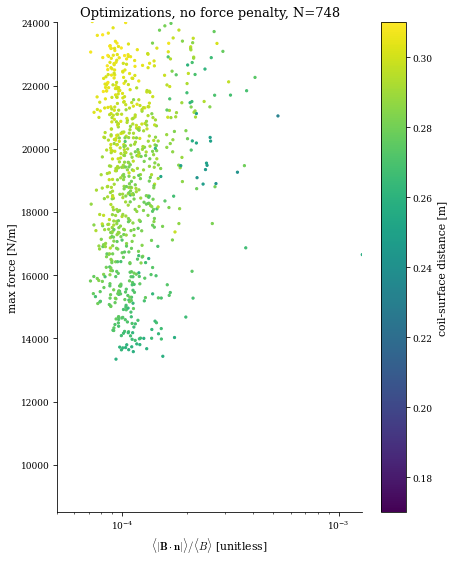

In [4]:
df, df_filtered, df_pareto = get_dfs(INPUT_DIR='./output/QA/without-force-penalty/1/optimizations/')

fig = plt.figure(figsize=(6.5, 8))
plt.rc("font", size=13)
markersize = 5
n_pareto = df_pareto.shape[0]
n_filtered = df_filtered.shape[0] - n_pareto
color="coil_surface_distance"
color_label="coil-surface distance [m]"
norm = plt.Normalize(min(df_filtered[color]), max(df_filtered[color]))
plt.scatter(
    df_filtered["normalized_BdotN"],
    df_filtered["max_max_force"],
    c=df_filtered[color],
    s=markersize,
    norm=norm
)
plt.xlabel(r'$\langle|\mathbf{B}\cdot\mathbf{n}|\rangle/\langle B \rangle$ [unitless]')
plt.ylabel("max force [N/m]")
plt.xlim(0.7 * min(df_filtered["normalized_BdotN"]), max(df_filtered["normalized_BdotN"]))
plt.ylim(8500, 24000)
plt.xscale("log")
plt.colorbar(label=color_label)
plt.clim(0.17, 0.31)
plt.title(f'Optimizations, no force penalty, N={n_filtered}')
plt.show()

Let's also perform a continuation method. Since we don't have a Pareto front of sorts, let's just apply it to all optimizations that passed through our filters and take the 100 with the lowest normalized flux. For example, here is the process for the first continuation.

In [2]:
INPUT_DIR = "./output/QA/without-force-penalty/1/optimizations/"
OUTPUT_DIR = "./output/QA/without-force-penalty/1/pareto/"
_, df_filtered, _ = get_dfs(INPUT_DIR=INPUT_DIR)
df_sorted = df_filtered.sort_values(by=["normalized_BdotN"])

if os.path.exists(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR)
os.makedirs(OUTPUT_DIR, exist_ok=True)

for UUID in df_sorted[:100]['UUID']:
    SOURCE_DIR = glob.glob(f"./**/{UUID}/", recursive=True)[0] 
    DEST_DIR = f"{OUTPUT_DIR}{UUID}/"
    shutil.copytree(SOURCE_DIR, DEST_DIR)

In [ ]:
# INPUT_DIR="./output/QA/without-force-penalty/1/pareto/"
# OUTPUT_DIR="./output/QA/without-force-penalty/2/optimizations"
# for i in range(1000): continuation(N=1, dx=10**rand(-3, -1.3), INPUT_DIR=INPUT_DIR, OUTPUT_DIR=OUTPUT_DIR)

Let's then look to see how well the method works!

/var/folders/qx/zl9pfmpn3yz5f62mt03d1m5w0000gs/T/ipykernel_62143/2370832889.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  norm = plt.Normalize(1, np.sum(os.path.isdir(os.path.join("./output/QA/without-force-penalty", f)) for f in os.listdir("./output/QA/without-force-penalty")))


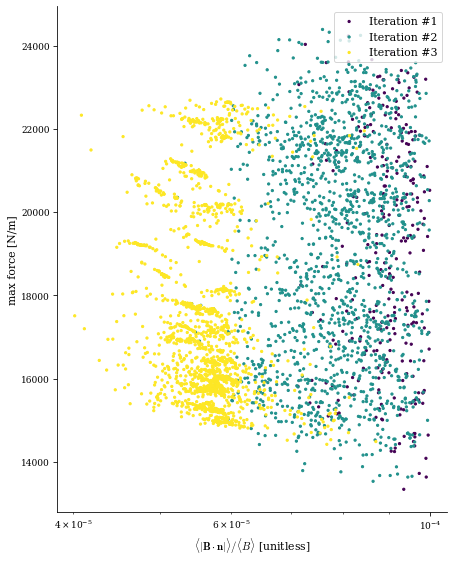

In [4]:
fig = plt.figure(figsize=(6.5, 8))
norm = plt.Normalize(1, np.sum(os.path.isdir(os.path.join("./output/QA/without-force-penalty", f)) for f in os.listdir("./output/QA/without-force-penalty")))
plt.rc("font", size=13)
for filename in sorted(os.listdir("./output/QA/without-force-penalty")):
    f = os.path.join("./output/QA/without-force-penalty", filename)
    if os.path.isdir(f):
        _, df, _ = get_dfs(INPUT_DIR = f + "/optimizations/")
        df = df.query(f"normalized_BdotN < 1e-4")
        plt.scatter(
            df["normalized_BdotN"],
            df["max_max_force"],
            s=5,
            c=int(filename)*np.ones(len(df["UUID"])),
            label=f"Iteration #{filename}",
            norm=norm
        )
        
plt.xlabel(r'$\langle|\mathbf{B}\cdot\mathbf{n}|\rangle/\langle B \rangle$ [unitless]')
plt.ylabel("max force [N/m]")
# plt.xlim(0.7 * min(df["normalized_BdotN"]), max(df["normalized_BdotN"]))
# plt.ylim(7000, 18000)
plt.xscale("log")
plt.legend(loc='upper right', fontsize='11')
plt.show()

#### Comparison

Here, we perform a linear regression of maximum force against normalized flux and coil-surface distance as these are the three most strongly correlated terms. 

DESC version 0.11.1,using JAX backend, jax version=0.4.30, jaxlib version=0.4.30, dtype=float64
Using device: CPU, with 15.62 GB available memory
The equation for with force penalty is z = -1467.84 + 1775.55x + 82237.06y with R^2 = 0.98
The equation for without force penalty is z = 13813.18 + 11632.46x + 179073.76y with R^2 = 0.68


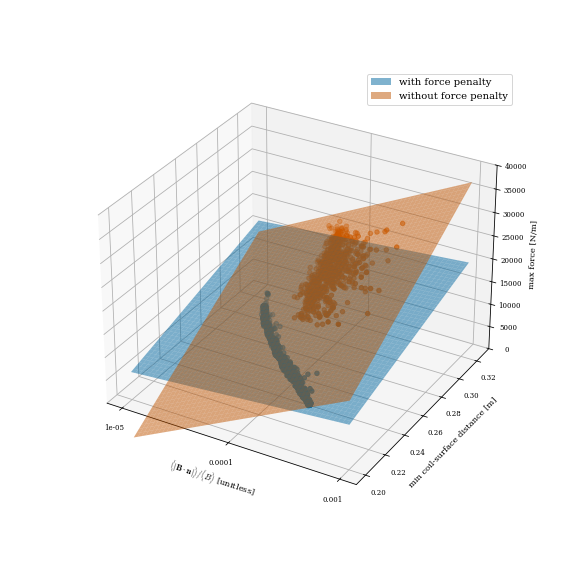

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn.linear_model
import warnings
from analysis_tools import *
from mpl_toolkits.mplot3d import Axes3D

%matplotlib widget

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel(r"$\langle|\mathbf{B}\cdot\mathbf{n}|\rangle/\langle B \rangle$ [unitless]")
ax.set_ylabel("min coil-surface distance [m]") 
ax.set_zlabel("max force [N/m]")
warnings.filterwarnings("ignore", category=UserWarning)

#Matplotlib isn't amenable to log axes in 3D, so do it manually:
xticks = [1e-5, 1e-4, 1e-3]
ax.set_xticks(np.log10(xticks))
ax.set_xticklabels(xticks)
ax.set_zlim(0, 40000)

INPUT_DIRS = ["./output/QA/with-force-penalty/4/optimizations/", 
              "./output/QA/without-force-penalty/1/optimizations/"]
labels     = ["with force penalty", "without force penalty"]

for INPUT_DIR, label in zip(INPUT_DIRS, labels):
    # Import data from final Pareto front
    _, df_filtered, _ = get_dfs(INPUT_DIR=INPUT_DIR)

    # There is a discontinuity in the coil-surface distance around a normalized
    # flux of 0.4e-3. We'll only consider data below this point as (a) eliminating
    # a discontinuity will provide a more accurate linear regression, and (b) we're
    # only interested in points with a relatively low normalized flux.
    df_filtered = df_filtered.query(f"normalized_BdotN < 0.4e-3") 

    # Raw data
    x     = np.array(df_filtered["normalized_BdotN"])
    y     = np.array(df_filtered["coil_surface_distance"])
    z     = np.array(df_filtered["max_max_force"])
    log_x = np.log10(x)

    # Regression data
    model = sklearn.linear_model.LinearRegression()
    model.fit(np.c_[log_x,y], z)
    coefs = model.coef_
    intercept = model.intercept_
    xs = np.tile(np.linspace(-5, -3, 100), (100, 1))
    ys = np.tile(np.linspace(0.20, 0.325, 100), (100, 1)).T
    zs = xs*coefs[0]+ys*coefs[1]+intercept

    print((f"The equation for {label} is z = {intercept:.2f}"
          f" + {coefs[0]:.2f}x + {coefs[1]:.2f}y"
          f" with R^2 = {model.score(np.c_[log_x,y], z):.2f}"))

    ax.scatter(log_x, y, z) 
    ax.plot_surface(xs,ys,zs, alpha=0.5, label=label)
    
plt.legend()
plt.tight_layout()
plt.show()

In a 2D sense, the data would look like this...

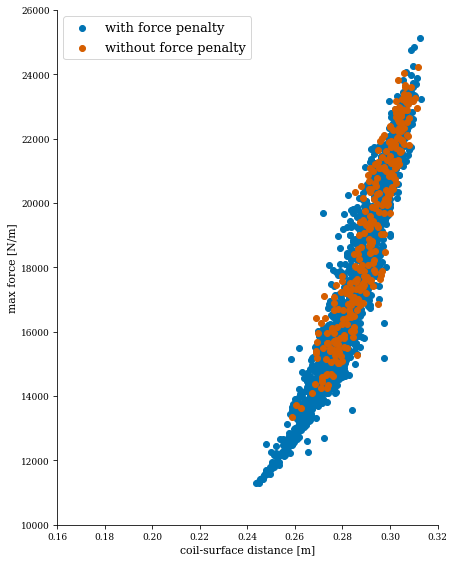

: 

In [6]:
_, df_with_penalty, _    = get_dfs()
_, df_without_penalty, _ = get_dfs(INPUT_DIR='./output/QA/without-force-penalty/1/optimizations/')

df_with_penalty    = df_with_penalty.query(f"normalized_BdotN < 1e-4")
df_without_penalty = df_without_penalty.query(f"normalized_BdotN < 1e-4")

fig = plt.figure(figsize=(6.5, 8))
plt.rc("font", size=13)
plt.scatter(
    df_with_penalty["coil_surface_distance"],
    df_with_penalty["max_max_force"],
    # s=5,
    label="with force penalty"
)
plt.scatter(
    df_without_penalty["coil_surface_distance"],
    df_without_penalty["max_max_force"],
    # s=5,
    label="without force penalty"
)
plt.ylabel("max force [N/m]")
plt.xlabel("coil-surface distance [m]")
plt.ylim(10000, 26000)
plt.lim(0.16, 0.32)
plt.legend()
plt.show()

### Magnetic Field Analysis


#### Computing Equilibria

First, we need to compute and save the equilibria for all configurations on the Pareto front as this is the most time-intentive task.

In [ ]:
# IN_PATH = "./output/QA/4/pareto/"
# UUIDs = [f.name for f in os.scandir(IN_PATH) if f.is_dir()]
# for UUID in UUIDs:
#     if not "eq.h5" in os.listdir(f"./output/QA/with-force-penalty/4/pareto/{UUID}/"):
#         qfm_surf, _, _ = qfm(UUID)
#         desc_eq = surf_to_desc(qfm_surf)
#         desc_eq.save(IN_PATH + UUID + "/eq.h5")
#         print(f"Saved {UUID}")

#### Quasisymmetry Measures

Let's export $|\textbf{B}|$ plots in Boozer coordinates for each coil set in the final Pareto front.

In [ ]:
# IN_PATH = "./output/QA/4/pareto/"
# UUIDs = [f.name for f in os.scandir(IN_PATH) if f.is_dir()]
# for UUID in UUIDs:
#     IN_PATH = f"./output/QA/4/pareto/{UUID}/eq.h5"
#     eq = desc.io.load(IN_PATH)
#     fig, ax = plot_boozer_surface(eq)
#     SOURCE_DIR = glob.glob(f"./**/{UUID}/", recursive=True)[0] 
#     EXPORT_PATH = SOURCE_DIR + "B.jpg"
#     plt.savefig(EXPORT_PATH)
#     plt.close()
#     print(f"Exported UUID {UUID}")

In [ ]:
UUIDs = ["6266c8d4bb25499b899d86e9e3dd2ee2", "c3c984ea02624607b8a59a9fdf0642dd"]
for UUID in UUIDs:
    IN_PATH = "./output/QA/4/pareto/"
    img = matplotlib.image.imread(IN_PATH + UUID + "/B.jpg")
    plt.figure()
    imgplot = plt.imshow(img)

Now, let's create a `.gif` of all the |B| plots!

In [ ]:
df_final, df_filtered_final, df_pareto_final = get_dfs(INPUT_DIR='./output/QA/4/optimizations/')
sorted_pareto = df_pareto_final.sort_values(by=["max_forces"], ascending=False)
images = []
for UUID in sorted_pareto['UUID']:
    path = "./output/QA/4/pareto/" + UUID + "/B.jpg"    
    images.append(imageio.imread(path))
create_movies(images, "pareto_B", "./output/QA/4/")

<img src="./output/QA/with-force-penalty/4/pareto_B.gif" width="350" align="center">

By comparison, here's the target equilibrium!

In [ ]:
target_eq = desc.io.load("./inputs/LandremanPaul2021_QA.h5")
fig, ax = plot_boozer_surface(target_eq)
plt.show()

Now, let's examine numerical quasisymmetry metrics. Here, the solid lines represent the target equilibrium, while the dashed ones represent the stage-II equilibrium. The three metrics shown are (1) the two-term error function $f_C$ defined on the LCFS, the triple product objective $f_T$ defined throughout the volume, and (3) the Boozer objective $f_B$. 

In [ ]:
# target_eq = desc.io.load("./inputs/LandremanPaul2021_QA.h5")
# IN_PATH = "./output/QA/4/pareto/"
# UUIDs = [f.name for f in os.scandir(IN_PATH) if f.is_dir()]
# for UUID in UUIDs:
#     IN_PATH = f"./output/QA/4/pareto/{UUID}/eq.h5"
#     eq = desc.io.load(IN_PATH)
#     fig = plt.figure()
#     ax = fig.add_subplot() 
#     ax.set_ylim(1e-7, 1e-1)
#     desc.plotting.plot_qs_error(eq, ls=["--", "--", "--"], marker=["", "", ""], ax=ax)
#     desc.plotting.plot_qs_error(target_eq, marker=["", "", ""], ax=ax, legend=False)
#     SOURCE_DIR = glob.glob(f"./**/{UUID}/", recursive=True)[0] 
#     EXPORT_PATH = SOURCE_DIR + "qs.jpg"
#     plt.savefig(EXPORT_PATH)
#     plt.close()
#     print(f"Exported UUID {UUID}")

In [ ]:
UUIDs = ["6266c8d4bb25499b899d86e9e3dd2ee2", "c3c984ea02624607b8a59a9fdf0642dd"]
for UUID in UUIDs:
    IN_PATH = "./output/QA/4/pareto/"
    img = matplotlib.image.imread(IN_PATH + UUID + "/qs.jpg")
    plt.figure()
    imgplot = plt.imshow(img)

As before, let's create a `.gif`!

In [ ]:
df_final, df_filtered_final, df_pareto_final = get_dfs(INPUT_DIR='./output/QA/with-force-penalty/4/optimizations/')
sorted_pareto = df_pareto_final.sort_values(by=["max_forces"], ascending=False)
images = []
for UUID in sorted_pareto['UUID']:
    path = "./output/QA/with-force-penalty/4/pareto/" + UUID + "/qs.jpg"    
    images.append(imageio.imread(path))
create_movies(images, "pareto_qs", "./output/QA/4/")

<img src="./output/QA/with-force-penalty/4/pareto_qs.gif" width="350" align="center">


#### Fast Particle Tracing

First, we need to scale the equilibria to the minor radius and volume-averaged magnetic field of ARIES-CS for each configuration we seek to analyze..

In [ ]:
# import desc
# import os
# from desc.vmec import VMECIO

# IN_PATH = "./output/QA/with-force-penalty/4/pareto/"
# UUIDs = [f.name for f in os.scandir(IN_PATH) if f.is_dir()]
# for UUID in UUIDs:
#     eq = desc.io.load(f"./output/QA/4/pareto/{UUID}/eq.h5")
#     eq_scaled = desc.compat.rescale(eq, ('a', 1.7), ('<B>', 5.86))
#     eq_scaled.save(f"./output/QA/4/pareto/{UUID}/eq_scaled.h5")
#     VMECIO.save(eq_scaled, f"./output/QA/4/pareto/{UUID}/eq_scaled.nc", verbose=0)
#     print(f"Saved {UUID}")

Now, let's run SIMPLE.

In [ ]:
IN_PATH = "./output/QA/with-force-penalty/4/pareto/"
UUIDs = [f.name for f in os.scandir(IN_PATH) if f.is_dir()]
for UUID in UUIDs:
    if not "confined_fraction.dat" in os.listdir(f"./output/QA/with-force-penalty/4/pareto/{UUID}/"):
        run_SIMPLE(UUID, trace_time=2e-1, n_test_part=5000, suppress_output=True)
        print(f"Traced {UUID}")

Note that I set up the file "SIMPLE.py" in the "HPC files" directory in order to facilitate these calculations on an HPC system. When ran, it will automatically perform fast particle tracing in an embarassingly parallel scheme by create a single slurm file per optimization we wish to analyze. 

`$ python SIMPLE.py`

In [ ]:
plot_losses("/Users/sienahurwitz/Documents/Physics/Projects/2023-Force Optimizations/Force Optimizations/output/QA/4/pareto/0a0ef2e8c01743888ced32dd4c0b0c1d/confined_fraction.dat")

#### Poincaré Plots

Here, we make Poincare plots of the field.

In [ ]:
for UUID in ['49d67fc2af7e418a95abd1b56613bf03', '13b5e759418c4d29b5b826acc90f5cb9']:
    image = poincare(UUID, OUT_DIR='1/poincare')
    plt.imshow(image)

## Landreman-Paul 2021 Precise QH + Well


### Ensemble of Optimizations <a id='1'></a>

##### With Force Penalty <a id='2'></a>

As before, we begin with some cold start optimizations.

In [ ]:
# OUTPUT_DIR="./output/QH/with-force-penalty/1/optimizations/"
# INPUT_FILE="./inputs/input.LandremanPaul2021_QH_magwell"
# initial_optimizations()